# Imports

In [1]:
from __future__ import print_function

# import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
# import plotly
# import plotly_express as px
# import plotly.graph_objects as go
import numpy as np
import re

from transformers import pipeline

# mpl.rcParams["figure.dpi"] = 300
# # %matplotlib inline
# %config InlineBackend.figure_format ='retina'


/Users/yasmeenmahomedy2/.pyenv/versions/3.10.6/envs/conflict_prediction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-06 15:32:40.489820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [113]:
df = pd.read_csv('/Users/yasmeenmahomedy2/Downloads/Conflict Datasets/un-general-debates.csv')

In [114]:
df = pd.DataFrame(df)
df.tail()

,session,year,country,text
7502,56,2001,KAZ,﻿This session\nthat is taking place under extr...
7503,56,2001,LBR,﻿I am honoured to\nparticipate in this histori...
7504,56,2001,BDI,﻿It\nis for me a signal honour to take the flo...
7505,56,2001,HUN,"﻿First, may I congratulate Mr. Han Seung-soo o..."
7506,56,2001,KWT,"﻿On behalf of the State of Kuwait, it\ngives m..."


In [115]:
x = df.groupby(by='country').mean()

/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/1564603617.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [142]:
x= pd.DataFrame(x)
x.index[150:200]

Index(['RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SMR',
       'SOM', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYC', 'SYR',
       'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON', 'TTO', 'TUN', 'TUR',
       'TUV', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 'UZB', 'VAT', 'VCT', 'VEN',
       'VNM', 'VUT', 'WSM', 'YDYE', 'YEM', 'YUG', 'ZAF', 'ZMB', 'ZWE'],
      dtype='object', name='country')

# Cleaning

In [16]:
updated = df[df['year']>=1990]

In [ ]:
#take out sesssion col?

# Sentiment

In [4]:
sentiment = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
)

2022-12-06 15:33:05.921364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [5]:
def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode(
        "ascii"
    )  # remove non-ascii, Chinese characters
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\t", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation and special characters
    text = re.sub(
        " +", " ", text
    ).strip()  # get rid of multiple spaces and replace with a single
    text = text[:500]
    return text


In [82]:
def sentiment_analysis(text):
    input_text = (
        pd.DataFrame(text.split("."))
        .stack()
        .reset_index()
        .rename(columns={0: "Paras"})
        .drop("level_0", axis=1)
        .drop("level_1", axis=1)
        .dropna()
    )

    input_text["Clean_Text"] = input_text["Paras"].map(lambda text: clean_text(text))

    corpus = list(input_text["Clean_Text"].values)

    input_text["Sentiment"] = sentiment(corpus)

    input_text["Sentiment_Label"] = [x.get("label") for x in input_text["Sentiment"]]

    input_text["Sentiment_Score"] = [x.get("score") for x in input_text["Sentiment"]]

    cols = ["Paras", "Sentiment_Label", "Sentiment_Score"]
    df = input_text[cols].copy()

    df = df[df["Paras"].str.strip().astype(bool)]

    df["Sentiment_Score"] = np.where(
        df["Sentiment_Label"] == "NEGATIVE",
        -(df["Sentiment_Score"]),
        df["Sentiment_Score"],
    )

    df["Sentiment_Score"] = df["Sentiment_Score"].round(6)

    overall_sentiment_score = df["Sentiment_Score"].sum().round(3)

    sentiment_count = df["Sentiment_Label"].value_counts().to_string()

#     return overall_sentiment_score, sentiment_count, df
    return df['Sentiment_Score'].mean()


In [11]:
df['Overall_Sentiment_Score'] = df['text'].apply(sentiment_analysis)

In [240]:
# pak['Overall_Sentiment_Score'] = pak['text'].apply(sentiment_analysis)


In [254]:
temp['text'][1]

'I come before the Assembly \ntoday in the name of my late wife, Shaheed Mohtarma \nBenazir Bhutto, as a victim of terrorism representing a \nnation that is a victim of terrorism. I am a husband who \nhas seen the mother of his children give her life \nfighting the menaces of terrorism and fanaticism, \nwhich haunt the entire civilized world. In her place and \nin her honour, I come before the Assembly as the \nelected President of a democratic Pakistan who \nreceived a mandate from two thirds of our Parliament \n  \n \n08-51851 16 \n \nand assemblies. That extraordinary mandate of support \nwas a vote of confidence in her, in her doctrine and in \nher message. The vote was an act of love and a demand \nfor a democratic, moderate, modern, tolerant and \neconomically just Pakistan — the essence of the Bhutto \ndoctrine. \n It has been 11 months since the first attack on my \nwife, on 18 October 2007, was followed by the \nadoption of a United Nations resolution calling for an \ninquiry 

In [256]:
temp = pak['text'].reset_index()
speech_0 = temp['text'][1]
start = round(len(speech_0)*0.1)
end = round(len(speech_0)*0.9)

speech_filter = speech_0[start:end]
sentiment_analysis(speech_filter)

0.21878489312977098

In [237]:
sentiment_analysis(speech_filter)
#speech 2

0.4263752685185184

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

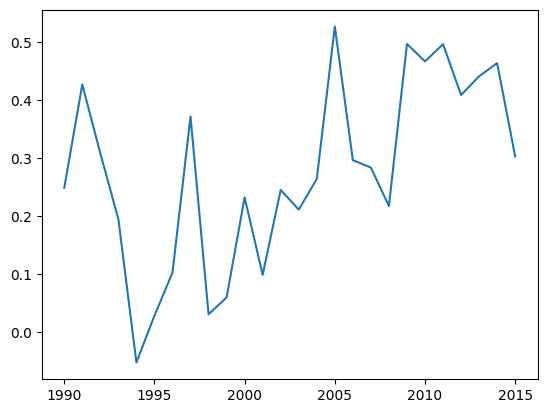

In [92]:
sns.lineplot(pak, x='year', y='Overall_Sentiment_Score')

In [257]:
px.line(pak, x='year', y='Overall_Sentiment_Score', )

### YEM

In [119]:
yemen = df[df['country']=='YEM']

In [121]:
yemen

,session,year,country,text
103,44,1989,YEM,﻿Allow me at the outset of my statement to exp...
265,68,2013,YEM,"Allow \nme, at the outset to extend sincere my..."
541,40,1985,YEM,"Mr. President, allow me at the outset to expre..."
736,63,2008,YEM,I should \nlike to start by congratulating Mr....
878,46,1991,YEM,﻿It gives me pleasure to congratulate the Pres...
936,41,1986,YEM,As I stand before the General Assembly today ...
1208,57,2002,YEM,"﻿At the\noutset, I would like to express to yo..."
1282,30,1975,YEM,\n109.\t I should like to extend to Mr. Gaston...
1534,51,1996,YEM,﻿It is a pleasure for me to warmly congratulat...
1575,67,2012,YEM,"﻿To begin\nwith, I offer my deep congratulatio..."


In [122]:
yemen['Overall_Sentiment_Score'] = yemen['text'].apply(sentiment_analysis)

/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/384499171.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
pd.DataFrame(yemen)

,session,year,country,text,Overall_Sentiment_Score
103,44,1989,YEM,﻿Allow me at the outset of my statement to exp...,0.471557
265,68,2013,YEM,"Allow \nme, at the outset to extend sincere my...",0.568229
541,40,1985,YEM,"Mr. President, allow me at the outset to expre...",0.244210
736,63,2008,YEM,I should \nlike to start by congratulating Mr....,0.452785
878,46,1991,YEM,﻿It gives me pleasure to congratulate the Pres...,0.429660
936,41,1986,YEM,As I stand before the General Assembly today ...,-0.048261
1208,57,2002,YEM,"﻿At the\noutset, I would like to express to yo...",0.281510
1282,30,1975,YEM,\n109.\t I should like to extend to Mr. Gaston...,0.591121
1534,51,1996,YEM,﻿It is a pleasure for me to warmly congratulat...,0.399745
1575,67,2012,YEM,"﻿To begin\nwith, I offer my deep congratulatio...",0.318084


In [182]:
yemen['Sentiment_label'] = np.where(yemen['Overall_Sentiment_Score']> 0, 'POSITIVE', 'NEGATIVE')
df.head()

/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/749616450.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [271]:
yemen['Sentiment_dif'] = np.where(yemen['Overall_Sentiment_Score']< 0.3, 'NEGATIVE', 'POSITIVE')
df.head()

/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/3339473026.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [272]:
# yemen['sentiment_label']=1
# for value in yemen['Overall_Sentiment_Score']:
#     if value > 0:
#         yemen['sentiment_label'] = 'POSITIVE'
#     elif value < 0:
#         yemen['sentiment_label'] = 'NEGATIVE'
#     else:
#         yemen['sentiment_label'] = 'NEUTRAL'

In [273]:
yemen[yemen['year']==2010]

,session,year,country,text,Overall_Sentiment_Score,sentiment_label,hasimage,Sentiment_label,Sentiment_label2,Sentiment_dif
2377,65,2010,YEM,"\nMr. President, on behalf of the Government o...",0.276942,POSITIVE,POSITIVE,POSITIVE,1,NEGATIVE


In [281]:
fig = go.Figure(
    data=go.Heatmap(
        z=yemen['Overall_Sentiment_Score'],
        x=yemen['year'],
        y=yemen["Sentiment_dif"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis"
    ),
    autosize=False,
    width=1200,
    height=400,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()

In [263]:
yemen['Sentiment_label2'] = 1

/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/183109323.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [279]:
fig = go.Figure(
    data=go.Heatmap(
        z=yemen['Overall_Sentiment_Score'],
        x=yemen['year'],
        y=yemen["Sentiment_label2"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis"
    ),
    autosize=False,
    width=1200,
    height=300,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

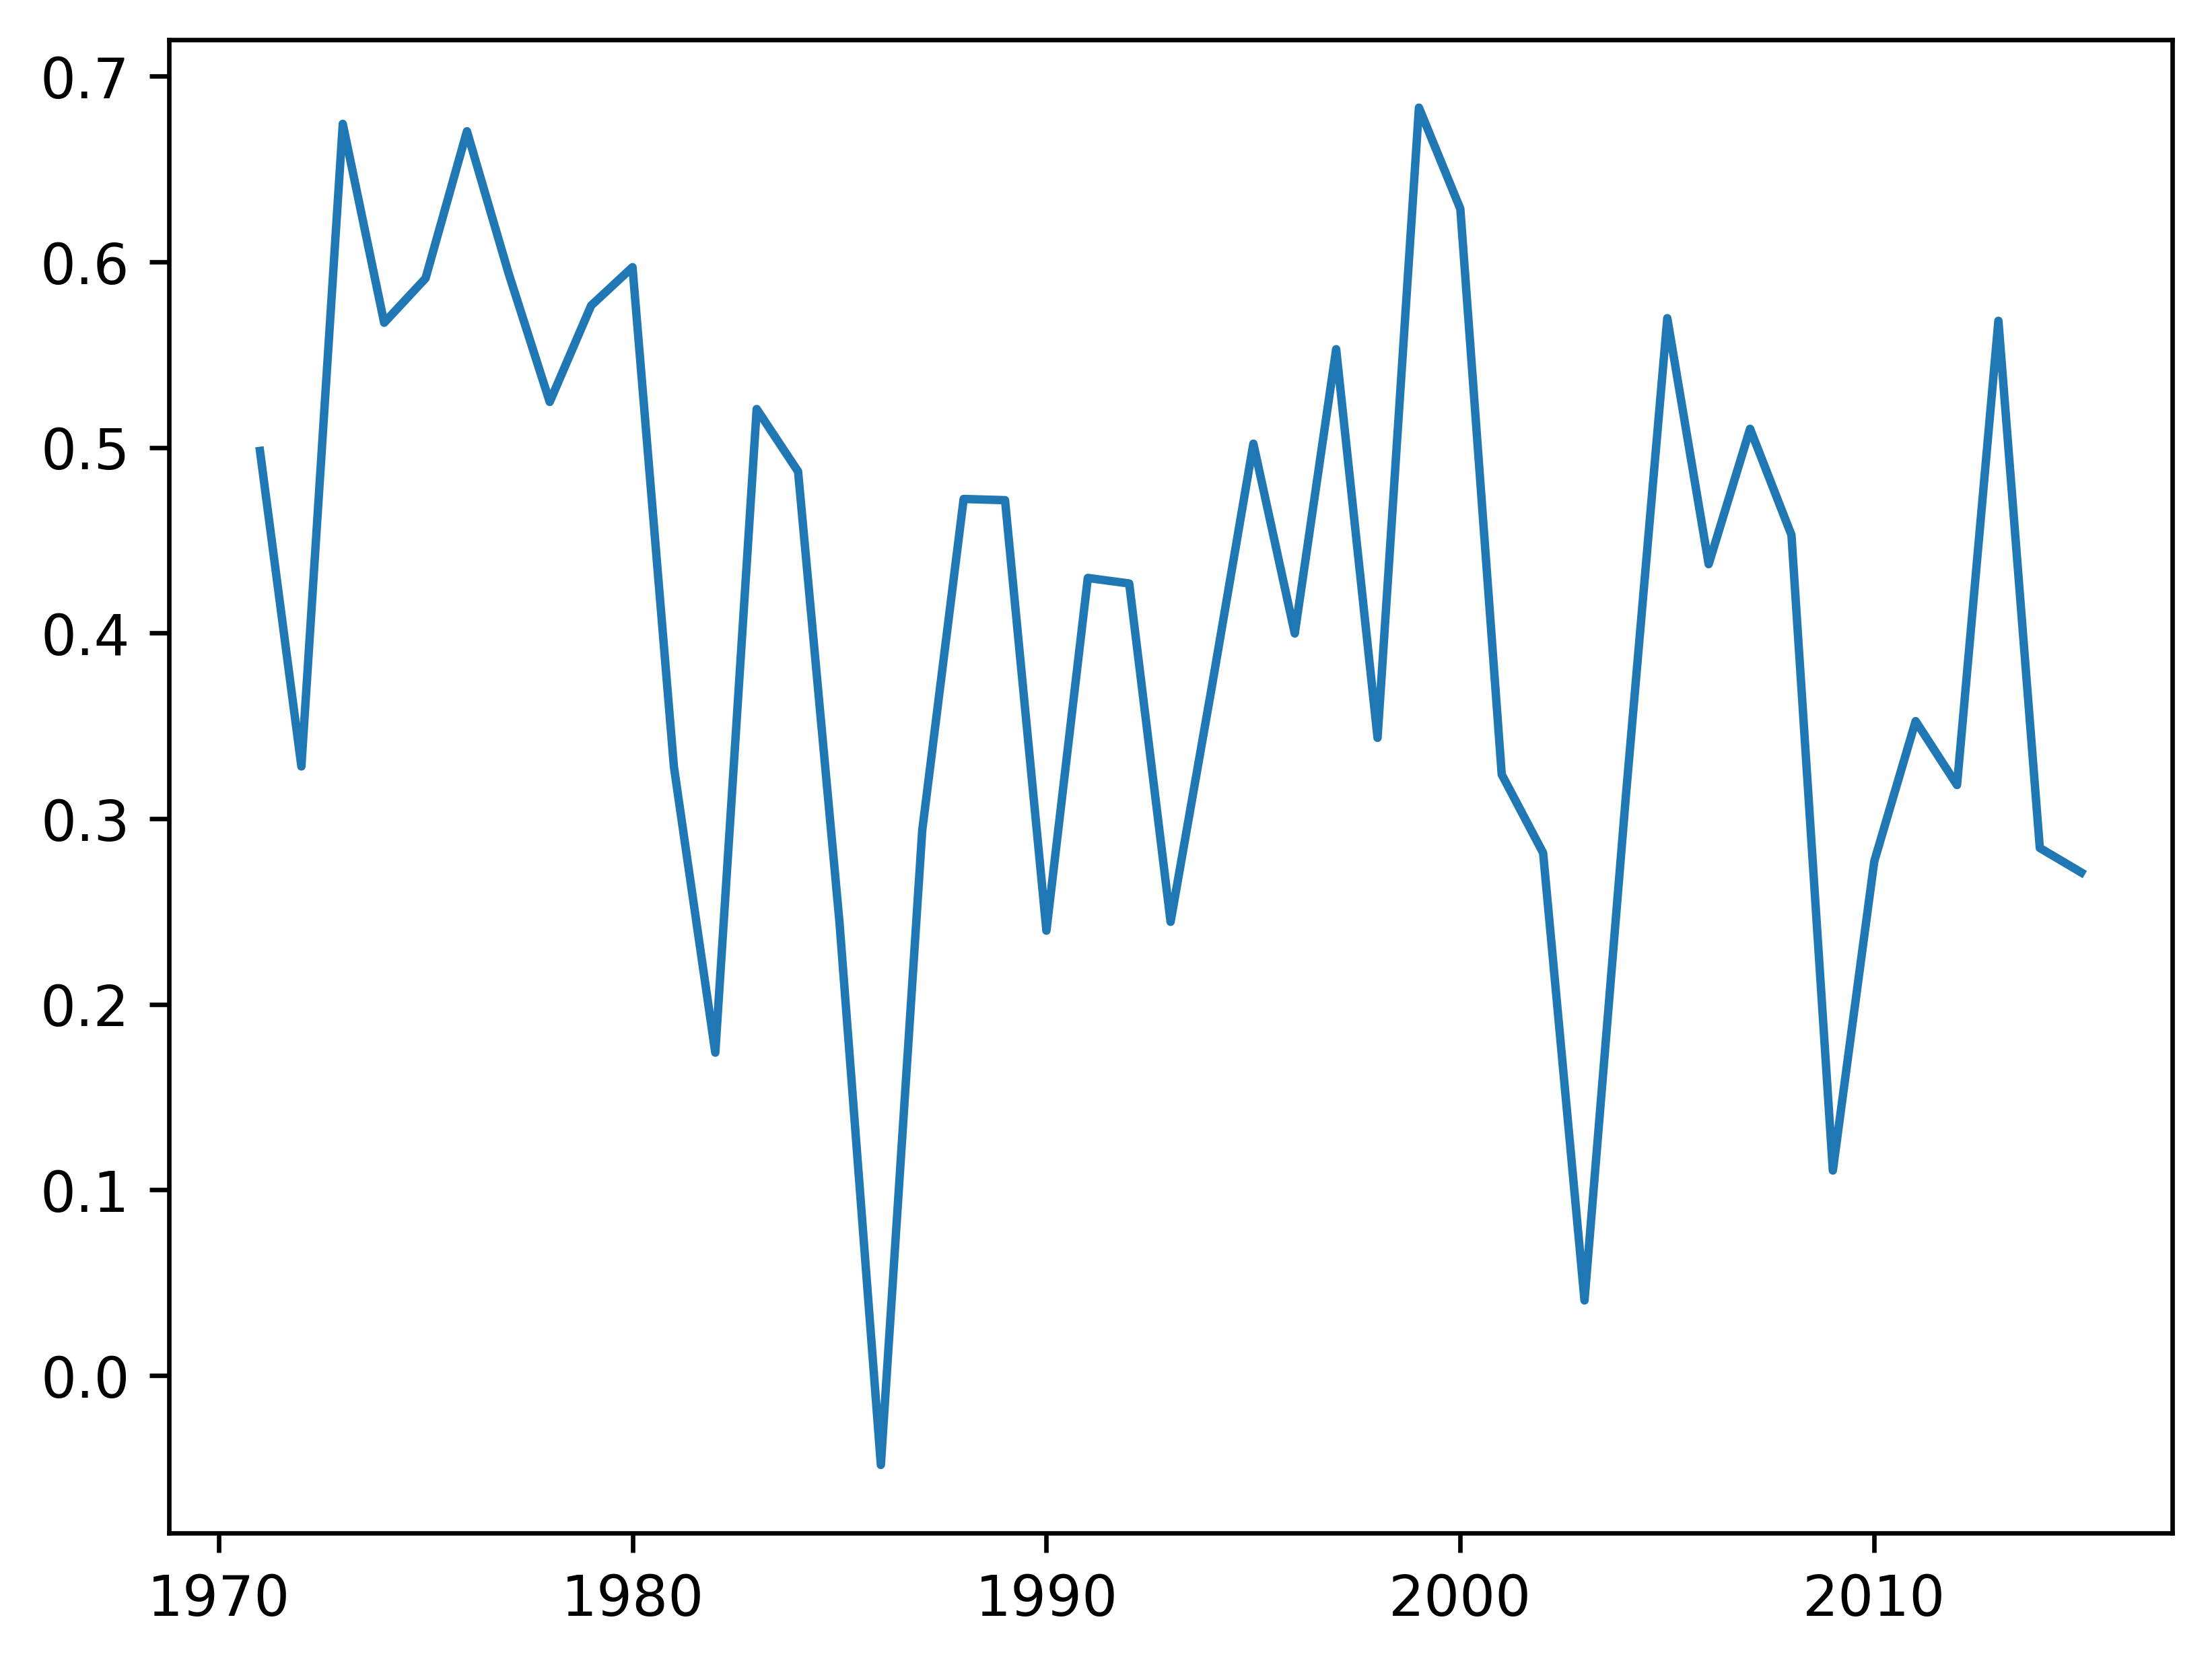

In [187]:
sns.lineplot(yemen, x='year', y='Overall_Sentiment_Score')

### TUN

In [143]:
tun = df[df['country']=='TUN']

In [144]:
tun['Overall_Sentiment_Score'] = tun['text'].apply(sentiment_analysis)

KeyboardInterrupt: 

In [155]:
tun[tun['year']==2001]

,session,year,country,text
7466,56,2001,TUN,﻿I am\npleased to begin by extending to Mr. Ha...


In [28]:
score, thing, first = sentiment_analysis(df['text'][0])

In [80]:
first['Sentiment_Score'].mean()

0.2171780569620253

In [ ]:
updated.head()

# Test on pakistan

In [19]:
pak = updated[updated['country']=='PAK']

In [39]:
pak['text'][739]

'I come before the Assembly \ntoday in the name of my late wife, Shaheed Mohtarma \nBenazir Bhutto, as a victim of terrorism representing a \nnation that is a victim of terrorism. I am a husband who \nhas seen the mother of his children give her life \nfighting the menaces of terrorism and fanaticism, \nwhich haunt the entire civilized world. In her place and \nin her honour, I come before the Assembly as the \nelected President of a democratic Pakistan who \nreceived a mandate from two thirds of our Parliament \n  \n \n08-51851 16 \n \nand assemblies. That extraordinary mandate of support \nwas a vote of confidence in her, in her doctrine and in \nher message. The vote was an act of love and a demand \nfor a democratic, moderate, modern, tolerant and \neconomically just Pakistan — the essence of the Bhutto \ndoctrine. \n It has been 11 months since the first attack on my \nwife, on 18 October 2007, was followed by the \nadoption of a United Nations resolution calling for an \ninquiry 

In [54]:

score, thing, first = sentiment_analysis(pak['text'][739])

In [58]:
thing

'POSITIVE    96\nNEGATIVE    62'

In [42]:
first['Sentiment_Score']

0.2171780569620253

In [77]:
first[['Paras', 'Sentiment_Score']][8:9]

,Paras,Sentiment_Score
8,"\n Today, we still do not know what forces an...",-0.998242


In [78]:
first['Paras'][8]

' \n Today, we still do not know what forces and \ninstitutions were involved — who plotted and planned \nand coordinated and trained and paid for the murder of \nmy wife, my nation’s beloved leader'

In [49]:
sentiment_analysis(' Ours is a bloody fight, and neither the personal \npain that my children and I feel nor the pain of a nation \nthat has been robbed of its greatest asset, its greatest \nleader, can be fully expressed')

(-0.997,
 'NEGATIVE    1',
                                                Paras Sentiment_Label  \
 0   Ours is a bloody fight, and neither the perso...        NEGATIVE   
 
    Sentiment_Score  
 0        -0.996724  )

In [199]:
test = 'Hi I like world peacr'

In [211]:
test[5:]

'like world peacr'

In [215]:
len(pak['text'][379].iloc[100:])

AttributeError: 'str' object has no attribute 'iloc'

In [81]:
pak

,session,year,country,text
379,68,2013,PAK,"I stand \nhere today before the Assembly, soon..."
739,63,2008,PAK,I come before the Assembly \ntoday in the name...
864,46,1991,PAK,"﻿Mr. President, it is with great pleasure that..."
1217,57,2002,PAK,"﻿I extend to you,\nMr. President, my felicitat..."
1542,51,1996,PAK,"﻿On behalf of 130 million\nPakistanis, please ..."
1639,67,2012,PAK,"﻿Before I begin my statement,\nI want to expre..."
1907,52,1997,PAK,﻿May I begin with a verse from\nthe Holy Koran...
2368,65,2010,PAK,I wish to congratulate \nthe President of the ...
2675,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
2858,64,2009,PAK,I am honoured to return to \nthis chamber of h...


In [35]:
pak['Overall_Sentiment_Score'] = pak['text'].apply(sentiment_analysis)

KeyboardInterrupt: 

In [157]:

import matplotlib as mpl
import pandas as pd
import plotly.graph_objects as go

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'


In [192]:
pak['Sentiment_label'] = np.where(pak['Overall_Sentiment_Score']> 0, 'POSITIVE', 'NEGATIVE')


/var/folders/ty/xzkrlw3n681fsxzmh9cl7wq00000gq/T/ipykernel_60385/456969755.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [195]:
fig = go.Figure(
    data=go.Heatmap(
        z=pak['Overall_Sentiment_Score'],
        x=pak['year'],
        y=pak["Sentiment_label"],
        colorscale=px.colors.sequential.RdBu,
    )
)

fig.update_layout(
    title=go.layout.Title(
        text="Sentiment Analysis"
    ),
    autosize=False,
    width=1200,
    height=600,
)

fig.update_layout(yaxis_autorange = "reversed")

fig.show()

In [283]:
iran = df[df['country']=='IRN']

In [284]:
len(iran)

46

## Random

In [ ]:
corpus = list(df['Clean_Text'].values)

In [ ]:
len(corpus)

In [ ]:
# sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

In [ ]:
from transformers import pipeline

sentiment = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
)

In [ ]:
sentiment

In [ ]:
len(corpus[0])

In [ ]:
corpus_lite = corpus[:100]

In [ ]:
df["Sentiment"] = sentiment_pipeline(corpus)

In [ ]:
sentiment_pipeline

In [ ]:
sentiment(corpus_lite)

In [ ]:
'distilbert-base-uncased-finetuned-sst-2-english'